In [121]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.fft import fft, ifft
from scipy.integrate import quad as integrate

/home/calab912/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/calab912/.local/lib/python3.8/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


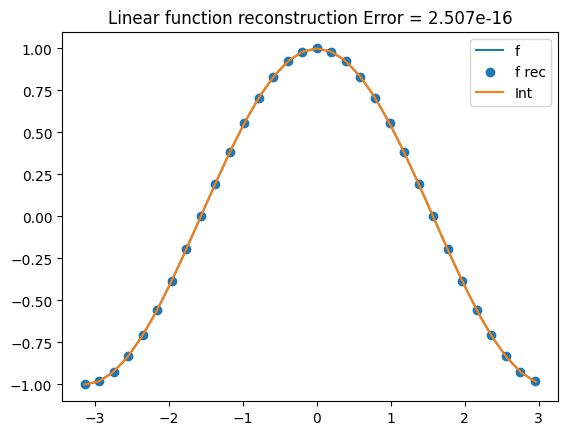

In [219]:
L = 2 * np.pi
N = 32
Ni = 34
x  = np.linspace(-np.pi, np.pi, N  + 1)[:-1]
xi = np.linspace(-np.pi, np.pi, Ni + 1)[:-1]

def getk(x): 
    k = np.arange(-len(x)/2, len(x)/2) / len(x)*2
    k = np.fft.ifftshift(k)
    return k 

def func(x): 
    return np.exp(1j*x)

def ddfunc(x): 
    return np.exp(1j*x)

f    = func(x) 
fhat = fft(f, norm="forward")
#fhat[int(N/2)] = 0
Npad = int(Ni/2 - N/2) 
ft   = np.fft.fftshift(fhat)
fpad = np.concatenate([np.zeros(Npad), ft, np.zeros(Npad)])
fpad = np.fft.fftshift(fpad)
frec = ifft(fhat, norm="forward")
fint = ifft(fpad, norm="forward")
plt.title(f"Linear function reconstruction Error = {np.mean(np.abs(fint - func(xi))):3.3e}") 
plt.plot(x, f, label="f")
plt.scatter(x, frec, label="f rec")
plt.plot(xi, fint, label="Int")
plt.legend()
plt.show()

## Define filters

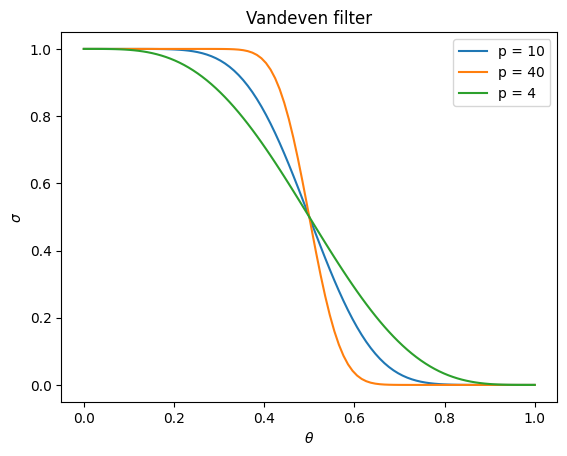

In [250]:
def sigma0(eta):
    return 1

def sigma1(eta):
    return 1 - eta 

def sigma2(eta):
    return np.sinc( np.pi * eta )

def sigma3(eta):
    return 0.5 * ( 1 + np.cos ( np.pi * eta ) ) 

def sigma4(eta):
    return sigma3(eta)**4 * ( 35 - 84 * sigma3(eta) + 70 * sigma3(eta)**2 - 20 * sigma3(eta)**3 )

def sigma5(eta, p = 8):
    alpha = 32
    return np.exp(-alpha*eta**p)

#Vandeven's filter of order p
def sigma6(eta, p = 10):
    c1 = np.math.factorial(2 * p - 1)/np.math.factorial(p - 1)**2
    def f(t):
        return (t * (1-t))**(p-1)
    
    sigmas = np.zeros(eta.shape) 
    for i, e in enumerate(eta): 
        c2, _ = integrate(func = f, a = 0, b = e)
        sigmas[i] = 1 - c1 * c2
    return sigmas
filters = [sigma0, sigma1, sigma2, sigma3, sigma4, sigma5, sigma6]

# Figure 1 
# The Erf½-LogFilter and the Asymptotics of the
# Euler and Vandeven Sequence Accelerations
# J. P. Boyd*
plt.title("Vandeven filter")
eta = np.linspace(0, 1, 100) 
plt.plot(eta, sigma6(eta, p=10), label="p = 10")
plt.plot(eta, sigma6(eta, p=40), label="p = 40")
plt.plot(eta, sigma6(eta, p=4) , label="p = 4")
plt.ylabel(r"$\sigma$")
plt.xlabel(r"$\theta$")
plt.legend()
plt.show() 
filters = [sigma0, sigma1, sigma2, sigma3, sigma4, sigma5, sigma6]

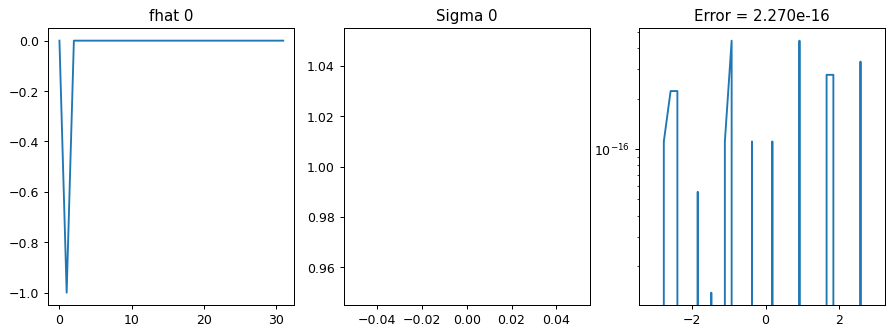

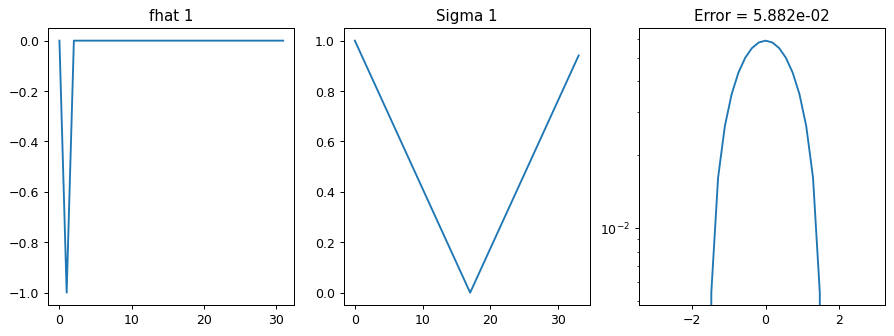

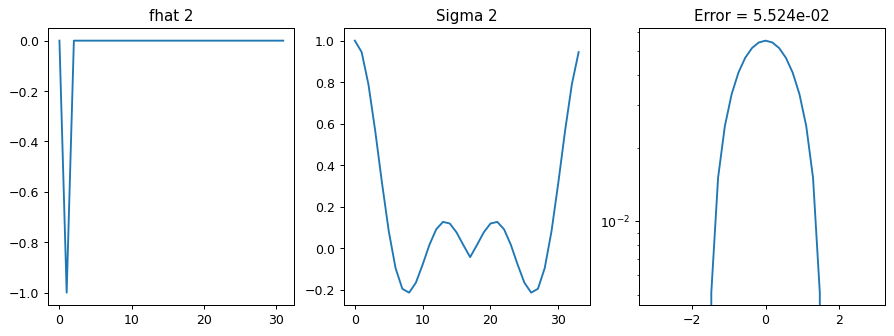

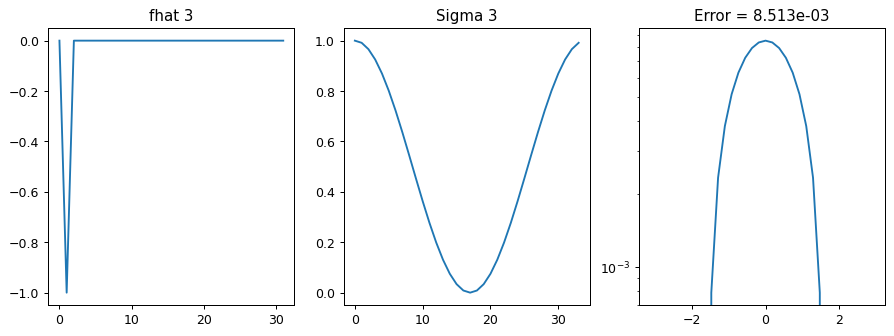

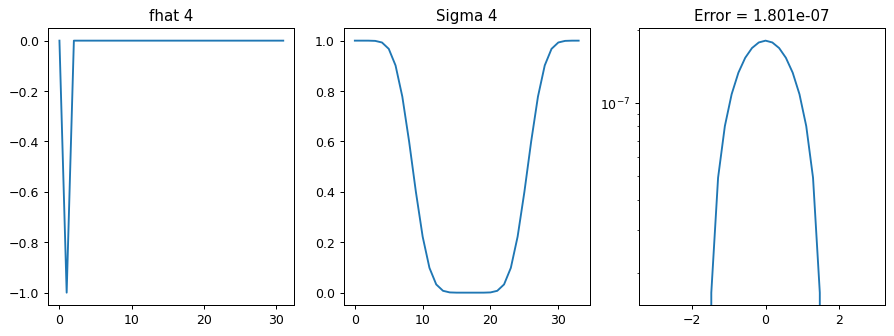

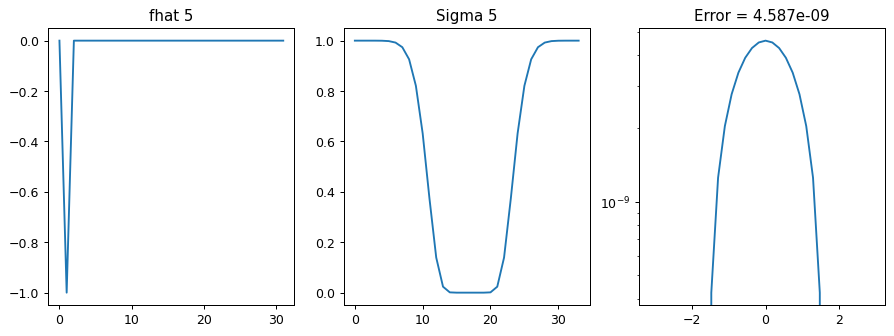

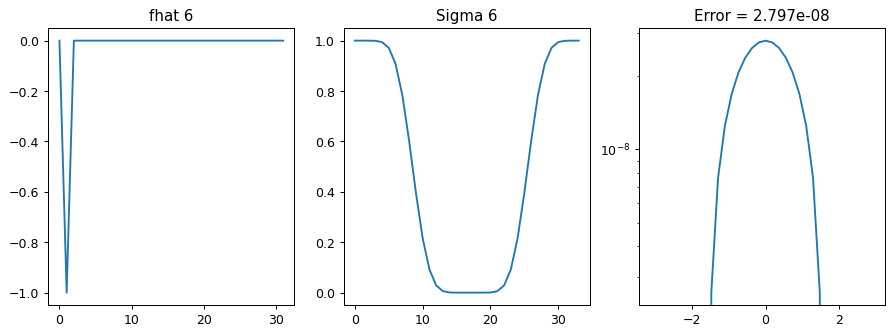

In [226]:


for i, filter in enumerate(filters):

    def sigma(x):
        k = getk(x)
        return filter(np.abs(k))
    
    fig, ax = plt.subplots(1, 3, figsize=(12,4),dpi=90)

    s = sigma(x)
    frec = ifft(fhat * s, norm="forward")
    s = sigma(xi)
    k = np.arange(-len(xi)/2, len(xi)/2)
    ax[0].set_title(f"fhat {i}") 
    ax[0].plot(fhat) 
    ax[1].set_title(f"Sigma {i}") 
    ax[1].plot(s) 
    fint = ifft(fpad * s, norm="forward")# * Ni/N 
    ax[2].set_title(f"Error = {np.mean(np.abs(fint[8:-8] - func(xi)[8:-8])):3.3e}") 
    ax[2].set_yscale("log")
    ax[2].plot(xi, func(xi) - fint, label="Int")
    plt.show()

## Compute evolution of superposition of plane waves by one time-step

Even if filters and mollifiers can achieve exponential convergence, one patch is too small for this approach

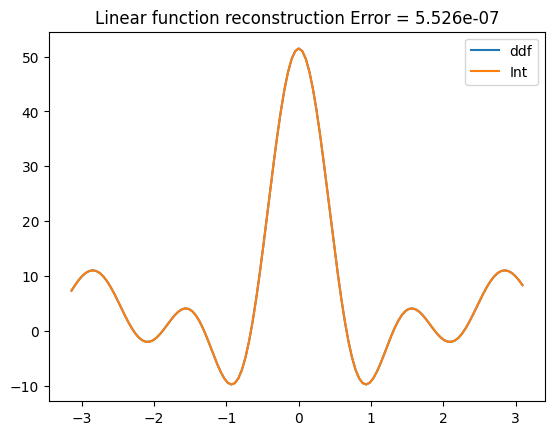

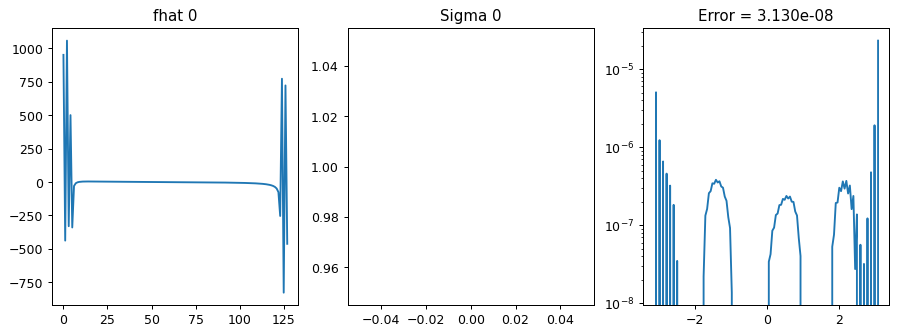

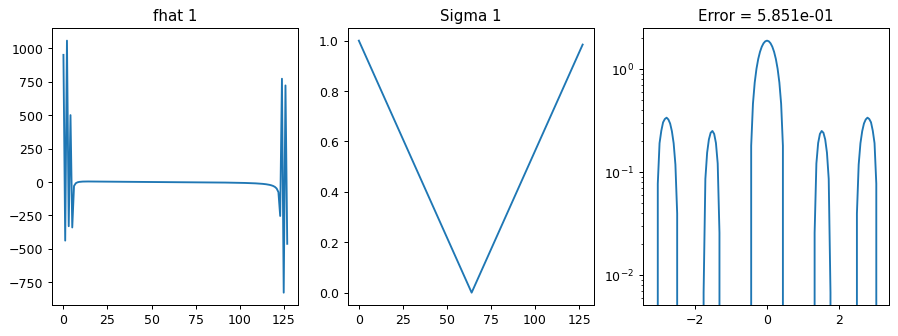

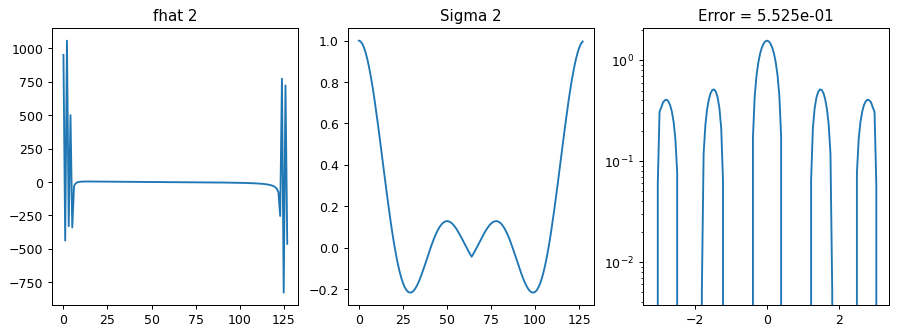

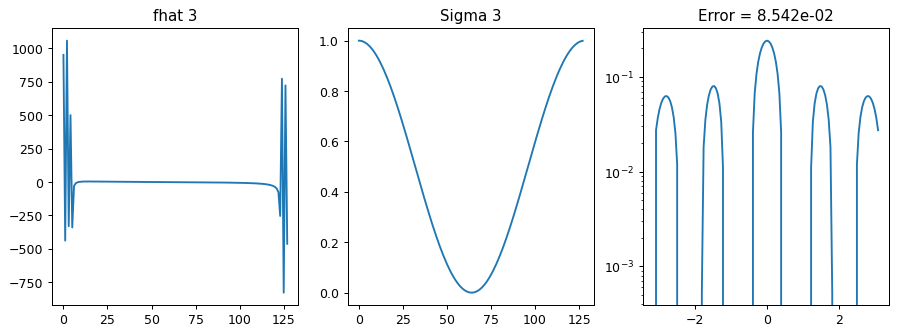

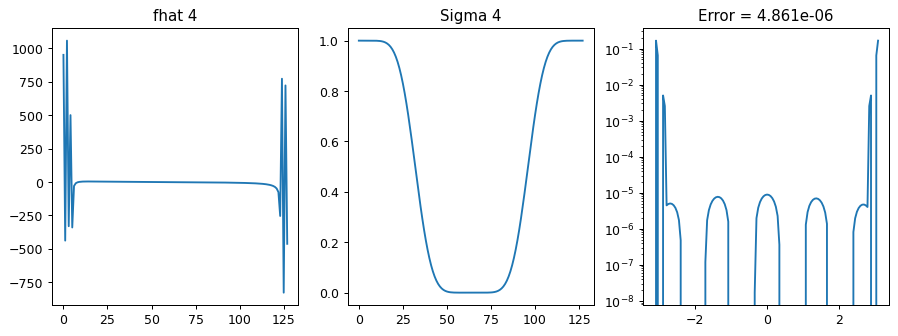

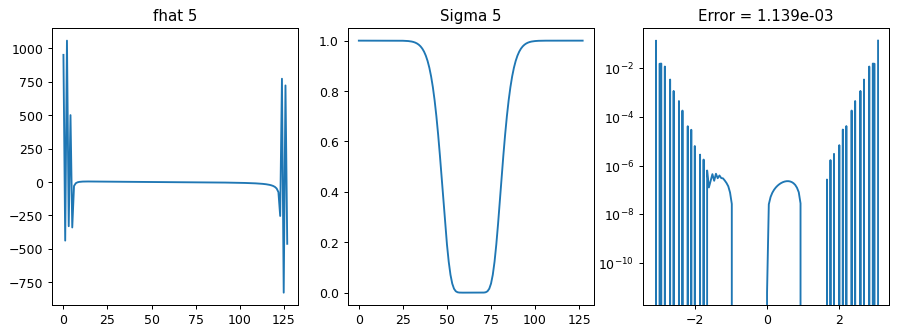

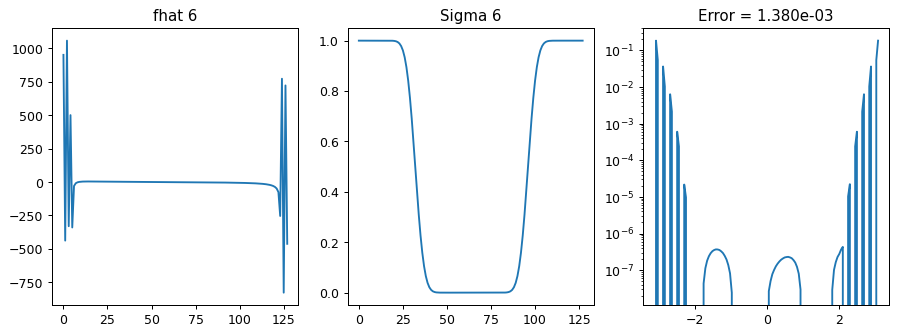

In [265]:
L = 2 * np.pi
N = 128
x  = np.linspace(-np.pi, np.pi, N  + 1)[:-1]
p = 1.3
dt = 1e-8 

amplitudes  =  np.random.rand(100)
momenta     = (np.random.rand(100) - 0.5) * 10

def getk(x): 
    k = 2*np.pi/L * np.arange(-len(x)/2, len(x)/2)
    k = np.fft.ifftshift(k)
    return k 

def func(x): 
    f = np.zeros(x.shape, dtype=complex)
    for A, p in zip(amplitudes, momenta):
        f += A * np.exp(1j * x * p)
    return f 

def ddfunc(x): 
    f = np.zeros(x.shape, dtype=complex)
    for A, p in zip(amplitudes, momenta):
        f += A * np.exp(1j * (x * p - p**2/2 * dt))
    return  f

f    = func(x) 
k    = getk(x) 
fhat = fft(f) * np.exp(-1j * 1/2 * dt * k**2)
fint = ifft(fhat)
plt.title(f"Linear function reconstruction Error = {np.mean(np.abs(fint - ddfunc(x))):3.3e}") 
plt.plot(x, ddfunc(x), label="ddf")
plt.plot(x, fint, label="Int")
plt.legend()
plt.show()

filters = [sigma0, sigma1, sigma2, sigma3, sigma4, lambda sig: sigma5(sig, 12), lambda sig: sigma6(sig, 32)]


for i, filter in enumerate(filters):

    def sigma(x):
        k = getk(x)
        N = len(x)/2
        return filter(np.abs(k)/N)
    
    fig, ax = plt.subplots(1, 3, figsize=(12,4),dpi=90)

    s = sigma(x)
    fint = ifft(fhat * s)
    ax[0].set_title(f"fhat {i}") 
    ax[0].plot(fhat) 
    ax[1].set_title(f"Sigma {i}") 
    ax[1].plot(s) 
    ax[2].set_title(f"Error = {np.mean(np.abs(fint[8:-8] - ddfunc(x)[8:-8])):3.3e}") 
    ax[2].set_yscale("log")
    ax[2].plot(x, func(x) - fint, label="Int")
    plt.show()